In [73]:
import torch
import pathlib

from typing import List, Optional, Dict
from torch.autograd import Variable
from scipy.optimize import minimize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Nile Data')

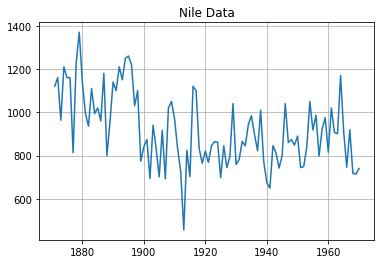

In [74]:
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
nile_path = data_dir / 'Nile.txt'

nile_dates = pd.read_csv(nile_path).index
nile_data = pd.read_csv(nile_path).values

fig, ax = plt.subplots()
ax.plot(range(1871, 1871 + len(nile_data)), nile_data)
ax.grid()
ax.set_title('Nile Data')

In [75]:
dtype = torch.FloatTensor

state_dim = 2
n = 100

alpha = Variable(torch.randn(state_dim, n).type(dtype), requires_grad=False)
T = Variable(torch.randn(state_dim, state_dim).type(dtype), requires_grad=True)

# no models w/ parameters in Z for now
Z = Variable(torch.randn(1, state_dim).type(dtype), requires_grad=True)

T.mm(alpha)

torch.inverse(T)

tensor([[ 1.5660,  0.2097],
        [-1.7791,  0.6479]], grad_fn=<InverseBackward0>)

In [76]:
def _mm3(M1: torch.tensor, M2: torch.tensor, M3: torch.tensor):
    """
    compute matrix product of 3 matrices
    """
    return torch.mm(torch.mm(M1, M2), M3)

In [77]:
def _bmm3(M1: torch.tensor, M2: torch.tensor, M3: torch.tensor):
    """
    compute batch matrix product of 3 matrices
    """
    return torch.bmm(torch.bmm(M1, M2), M3)

In [78]:
def _initiate_variables(p: int, s: int, n: int, dtype=torch.float64):
    return torch.zeros(p, 1, n).type(dtype), torch.zeros(p, 1, n).type(dtype), torch.zeros(p, p, n).type(dtype), torch.zeros(p, p, n).type(dtype), torch.zeros(s, 1, n).type(dtype), torch.zeros(s, s, n).type(dtype), torch.zeros(p, s, n).type(dtype), torch.zeros(p, s, n).type(dtype)

In [79]:
def _map_vector_to_matrices(params, param_map, *args):
    
    T, Z, R, Q, H = args

    for k, v in param_map.items():

        state_matrix_asstr = v[0]
        i, j, t = v[1]
        constant_through_time = v[2]

        if state_matrix_asstr == "Q":
            Q[i, j] = params[k]
        if state_matrix_asstr == "H":
            H[i, j] = params[k]
        if state_matrix_asstr == "T":
            T[i, j] = params[k]
        if state_matrix_asstr == "Z":
            Z[i, j] = params[k]
        if state_matrix_asstr == "R":
            R[i, j] = params[k]
    
    return T, Z, R, Q, H

In [80]:
# Will be forward method

def _kalman_step(T, Z, R, Q, H, a, P, y):
    """
    perform 1 step of the kalman filter
    """
    
    # prediction error: v
    v = y - torch.mm(Z, a)
    
    # prediction error variance: F
    F = _mm3(Z, P, Z.t()) + H
    
    # incast-kalman gain: M
    M = _mm3(P, Z.t(), torch.inverse(F)) 
    
    # kalman gain: K
    K = torch.mm(T, M)
    
    # incasted updates
    att = a + torch.mm(M, v)
    Ptt = P - _mm3(M, F, M.t())
    
    a_next = torch.mm(T, att)
    P_next = _mm3(T, Ptt, T.t()) + _mm3(R, Q, R.t())
    
    return a_next, P_next, att, Ptt, M, K, F, v

In [81]:
def kalman_filter(*args, diffuse=False):
    """
    perform all the steps of the Kalman filter
    """
    T, Z, R, Q, H, y = args
    
    # number of observations
    n = 100
    
    # dimension of state vector
    p = int(T.shape[0])
    
    # dimension of observation vector
    s = int(y.shape[0])
    
    # initiate filters (a, att), filter variances (P, Ptt), errors (v), error variances (F), and Kalman gains (K, M)
    a, att, P, Ptt, v, F, K, M = _initiate_variables(p, s, n)
    
    # do a diffuse initialization
    if diffuse:
        a[:, :, 0] = 0
        P[:, :, 0] = 1e7

    # iterate through time
    for t in range(1, n):
        
        # a[0] contains a1, y[0] contains y1
        y_t = y[:, :, t-1]
        a[:, :, t], P[:, :, t], att[:, :, t-1], Ptt[:, :, t-1], M[:, :, t-1], K[:, :, t-1], F[:, :, t-1], v[:, :, t-1] = _kalman_step(T, Z, R, Q, H, a[:, :, t-1], P[:, :, t-1], y_t)
    
    # do final incasting update
    y_t = y[:, :, n-1]
    _, _, att[:, :, n-1], Ptt[:, :, n-1], M[:, :, n-1], K[:, :, n-1], F[:, :, n-1], v[:, :, n-1] = _kalman_step(T, Z, R, Q, H, a[:, :, n-1], P[:, :, n-1], y_t)
    
    return a, att, P, Ptt, F, v, K, M 

In [85]:
def kalman_smoother(*args, dtype=torch.float64):
    """
    perform Kalman smoothing
    """
    T, Z, R, Q, H, a, P, v, F, K = args
    
    # number of observations
    n =  int(y.shape[2])
    
    # dimension of state vector
    p = int(T.shape[0])
    
    # dimension of observation vector
    s = int(y.shape[0])
    
    # instantiate a_hat
    a_hat = torch.zeros_like(a)
    
    # can einsum this operation because it does not iterate through time
    L = T - torch.einsum('ijk,ij->ijk', K, Z)
    
    # r[n+1] = r_n = 0
    r = torch.zeros(p, 1, n + 1).type(dtype)
    
    # a[0] contains a_1, y[0] contains y_1
    
    # from 99...0
    for t in range(n-1, -1, -1):
        
        r[:, :, t] = _mm3(Z.t(), torch.inverse(F[:, :, t]), v[:, :, t]) + torch.mm(L[:, :, t], r[:, :, t+1])
    
        a_hat[:, :, t] = a[:, :, t] + torch.mm(P[:, :, t], r[:, :, t])
        
    return a_hat

In [86]:
def log_likelihood(params, *args):
    
    T, Z, R, Q, H, y, param_map, diffuse = args
    T, Z, R, Q, H = _map_vector_to_matrices(params, param_map, T, Z, R, Q, H)
    
    # get means and variances
    _, _, _, _, F, v, _, _  = kalman_filter(T, Z, R, Q, H, y, diffuse=diffuse)
    
    # number of observations
    n =  int(y.shape[2])
    
    # dimension of state vector
    p = int(T.shape[0])

    # dimension of observation vector
    s = int(y.shape[0])
    
    # get elementwise log determinants log|F|
    F_logdets = torch.logdet(F.permute(2, 0, 1))
    
    # get elementwise v'F^(-1)v, then convert shape from [100, 1, 1] -> [100]
    vFv = torch.squeeze(_bmm3(v.permute(2, 1, 0), torch.inverse(F.permute(2, 0, 1)), v.permute(2, 0, 1)))
    
    # constant value 
    const = s * np.log(2 * np.pi) * torch.ones_like(vFv)
    
    # compute log-likelihood
    llik = -(1/2) * torch.sum(const + vFv + F_logdets) 
    
    negative_llik = -llik.item()
    
    return negative_llik

In [96]:
### Want all tensors to be of shape [dimension, 1/dimension ,n]

dtype=torch.float64

# load data, shape [s, n]
nile_data = pd.read_csv(nile_path).values
y = torch.Tensor(nile_data).type(dtype).t()

# get data into shape [s, 1, n]
y = y.expand(y.shape[0], 1, y.shape[1])

# Declare State Matrices Local Level Model -> use [[]] for extra dimension
T = torch.Tensor([[1]]).type(dtype)
Z = torch.Tensor([[1]]).type(dtype)
R = torch.Tensor([[1]]).type(dtype)
Q = torch.Tensor([[1]]).type(dtype)
H = torch.Tensor([[1]]).type(dtype)
diffuse = True

dict_param_llm = {
    0: ("Q", (0, 0, 0), True),
    1: ("H", (0, 0, 0), True)
}

llm_params_ini = np.array([500, 500])

# set options for minimization
options = {
    'eps': 1e-20,
    'disp': False
}

# since estimating variances, must be greater than 0
bnds = ((0, None), (0, None))

# maximize log-likelihook
res = minimize(log_likelihood, llm_params_ini, args=(T, Z, R, Q, H, y, dict_param_llm, diffuse), method='L-BFGS-B', options=options, bounds=bnds)             
print(res.x)

a, att, P, Ptt, F, v, K, M  = kalman_filter(T, Z, R, Q, H, y, diffuse=True)
a_hat = kalman_smoother(T, Z, R, Q, H, a, P, v, F, K)
llik = log_likelihood(llm_params, T, Z, R, Q, H, y, dict_param_llm, True)

#print(T.shape)
#print(llik)
#print(type(llik))

#torch.einsum('ijk,ij->ijk', K, Z)

[ 1467.71109906 15096.81336827]


tensor(42)
42


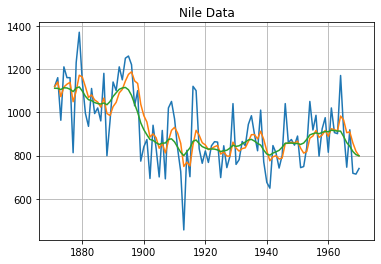

In [89]:
fig, ax = plt.subplots()
ax.plot(range(1871, 1871 + len(nile_data)), nile_data)
ax.plot(range(1871, 1871 + len(nile_data)), torch.squeeze(att).numpy())
ax.plot(range(1871, 1871 + len(nile_data)), torch.squeeze(a_hat).numpy())
ax.grid()
ax.set_title('Nile Data')

print(np.argmin(att))
print(np.argmin(nile_data))

In [16]:
# number of observations
n =  int(y.shape[2])

# dimension of state vector
p = int(T.shape[0])

# dimension of observation vector
s = int(y.shape[0])

In [17]:
F_logdets = torch.logdet(F.permute(2, 0, 1))
F_logdets.shape

torch.Size([100])

In [18]:
vFv = torch.squeeze(_bmm3(v.permute(2, 1, 0), torch.inverse(F.permute(2, 0, 1)), v.permute(2, 0, 1)))
vFv.shape

torch.Size([100])

In [20]:
torch.sum(vFv)

tensor(99.0975)

In [21]:
torch.sum(vFv + F_logdets) + n * s * np.log(2*np.pi)

tensor(1283.1711)

In [22]:
# loglik test #1
y_test = torch.ones(2,1,100)
F = torch.ones(2,2,100)
for i in range(100):
    F[:, :, i] = torch.eye(2,2)
y_test = torch.ones(2,1,100)
v_test = torch.ones(2,1,100)

# number of observations
n =  int(y_test.shape[2])

# dimension of observation vector
s = int(y_test.shape[0])

# get elementwise log determinants log|F|
F_logdets = torch.logdet(F.permute(2, 0, 1))
#print(torch.sum(F_logdets))
#print(F_logdets.shape)

# get elementwise v'F^(-1)v, then convert shape from [100, 1, 1] -> [100]
vFv = torch.squeeze(_bmm3(v_test.permute(2, 1, 0), torch.inverse(F.permute(2, 0, 1)), v_test.permute(2, 0, 1)))
#print(torch.sum(vFv))

# constant value 
const = s * np.log(2 * np.pi) * torch.ones_like(vFv)
    
# compute log-likelihood
llik = -(1/2) * torch.sum(const + vFv + F_logdets) 

# test -> see notes for calculation
assert round(llik.item(),0) == -284.0 

print('Test completed succesfully! ')

Test completed succesfully! 


In [41]:
param_dict_example = {
    0: ("Q", (0, 0, 0), True),
    1: ("H", (0, 0, 0), True)
}

params = np.array([500, 500])
Q = torch.Tensor([[0]]).type(dtype)
H = torch.Tensor([[0]]).type(dtype)

for k, v in param_dict_example.items():
    
    state_matrix_asstr = v[0]
    i, j, k = v[1]
    constant_through_time = v[2]
    
    if v[0] == "Q":
        Q[i, j] = params[k]
    if v[0] == "H":
        H[i, j] = params[k]
    if v[0] == "T":
        T[i, j] = params[k]
    if v[0] == "Z":
        Z[i, j] = params[k]
    if v[0] == "R":
        R[i, j] = params[k]
   
print(Q)
print(H)

tensor([[500.]])
tensor([[500.]])
